# NTU60 Dataset Exploratory Data Analysis

This notebook performs comprehensive EDA on the NTU60 skeleton action recognition dataset.

## Dataset Information
- **Actions**: 60 action classes
- **Joints**: 25 joints per skeleton
- **Persons**: Up to 2 persons per sample
- **Format**: Preprocessed NPZ files
- **Location**: `data/ntu/NTU60_CS.npz` (Cross-Subject) and `data/ntu/NTU60_CV.npz` (Cross-View)
- **Splits**: Cross-Subject (CS) and Cross-View (CV)

In [2]:
# Import required libraries
import numpy as np
import pandas as pd
import os
from collections import Counter, defaultdict
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

# Set style for better plots
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

# Set display options
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)

print("Libraries imported successfully!")

Libraries imported successfully!


## 1. Dataset Overview

### 1.1 Basic Statistics

In [ ]:
# Define paths
DATA_ROOT = Path('../data/ntu')
CS_DATA_PATH = DATA_ROOT / 'NTU60_CS.npz'
# CV_DATA_PATH = DATA_ROOT / 'NTU60_CV.npz'

# Load Cross-Subject split data
print("Loading NTU60 Cross-Subject (CS) data...")
cs_data = np.load(CS_DATA_PATH, allow_pickle=True)

print("\nCross-Subject Split:")
print(f"  Keys available: {list(cs_data.keys())}")
print(f"  x_train shape: {cs_data['x_train'].shape}")
print(f"  y_train shape: {cs_data['y_train'].shape}")
print(f"  x_test shape: {cs_data['x_test'].shape}")
print(f"  y_test shape: {cs_data['y_test'].shape}")

# # Load Cross-View split data
# print("\nLoading NTU60 Cross-View (CV) data...")
# cv_data = np.load(CV_DATA_PATH, allow_pickle=True)

# print("\nCross-View Split:")
# print(f"  Keys available: {list(cv_data.keys())}")
# print(f"  x_train shape: {cv_data['x_train'].shape}")
# print(f"  y_train shape: {cv_data['y_train'].shape}")
# print(f"  x_test shape: {cv_data['x_test'].shape}")
# print(f"  y_test shape: {cv_data['y_test'].shape}")

Loading NTU60 Cross-Subject (CS) data...

Cross-Subject Split:
  Keys available: ['x_train', 'y_train', 'x_test', 'y_test']
  x_train shape: (40091, 300, 150)
  y_train shape: (40091, 60)
  x_test shape: (16487, 300, 150)
  y_test shape: (16487, 60)

Loading NTU60 Cross-View (CV) data...

Cross-View Split:
  Keys available: ['x_train', 'y_train', 'x_test', 'y_test']
  x_train shape: (37646, 300, 150)
  y_train shape: (37646, 60)
  x_test shape: (18932, 300, 150)
  y_test shape: (18932, 60)


In [ ]:
# Extract labels from one-hot encoding
def extract_labels(y_onehot):
    """Convert one-hot encoded labels to class indices"""
    return np.where(y_onehot > 0)[1]

# Process CS split
cs_y_train = extract_labels(cs_data['y_train'])
cs_y_test = extract_labels(cs_data['y_test'])

# # Process CV split
# cv_y_train = extract_labels(cv_data['y_train'])
# cv_y_test = extract_labels(cv_data['y_test'])

print("\nDataset Statistics:")
print("=" * 60)
print("Cross-Subject (CS) Split:")
print(f"  Train samples: {len(cs_y_train)}")
print(f"  Test samples: {len(cs_y_test)}")
print(f"  Total samples: {len(cs_y_train) + len(cs_y_test)}")
print(f"  Action classes: {len(np.unique(np.concatenate([cs_y_train, cs_y_test])))}")
print(f"  Action range: {np.min(cs_y_train)} - {np.max(cs_y_train)}")

# print("\nCross-View (CV) Split:")
# print(f"  Train samples: {len(cv_y_train)}")
# print(f"  Test samples: {len(cv_y_test)}")
# print(f"  Total samples: {len(cv_y_train) + len(cv_y_test)}")
# print(f"  Action classes: {len(np.unique(np.concatenate([cv_y_train, cv_y_test])))}")
# print(f"  Action range: {np.min(cv_y_train)} - {np.max(cv_y_train)}")


Dataset Statistics:
Cross-Subject (CS) Split:
  Train samples: 40091
  Test samples: 16487
  Total samples: 56578
  Action classes: 60
  Action range: 0 - 59

Cross-View (CV) Split:
  Train samples: 37646
  Test samples: 18932
  Total samples: 56578
  Action classes: 60
  Action range: 0 - 59


### 1.2 Data Shape Analysis

In [5]:
# Reshape data to understand structure
# Original shape: (N, T, 2, 25, 3) where:
# N = number of samples
# T = temporal frames
# 2 = maximum persons
# 25 = joints per skeleton
# 3 = coordinates (X, Y, Z)

# Reshape CS train data
cs_x_train_reshaped = cs_data['x_train'].reshape(
    cs_data['x_train'].shape[0], 
    cs_data['x_train'].shape[1], 
    2, 25, 3
)

print("Data Structure Analysis:")
print("=" * 60)
print(f"\nCS Train Data:")
print(f"  Original shape: {cs_data['x_train'].shape}")
print(f"  Reshaped: (N={cs_x_train_reshaped.shape[0]}, T={cs_x_train_reshaped.shape[1]}, M={cs_x_train_reshaped.shape[2]}, V={cs_x_train_reshaped.shape[3]}, C={cs_x_train_reshaped.shape[4]})")
print(f"  Where:")
print(f"    N = Number of samples")
print(f"    T = Temporal frames (sequence length)")
print(f"    M = Maximum persons (2)")
print(f"    V = Vertices/Joints (25)")
print(f"    C = Coordinates (3: X, Y, Z)")

Data Structure Analysis:

CS Train Data:
  Original shape: (40091, 300, 150)
  Reshaped: (N=40091, T=300, M=2, V=25, C=3)
  Where:
    N = Number of samples
    T = Temporal frames (sequence length)
    M = Maximum persons (2)
    V = Vertices/Joints (25)
    C = Coordinates (3: X, Y, Z)


### 1.3 Action Class Distribution

Cross-Subject Split - Action Class Distribution:
   action  train  test  total  train_pct  test_pct
0       0    666   274    940       70.9      29.1
1       1    666   275    941       70.8      29.2
2       2    665   273    938       70.9      29.1
3       3    667   273    940       71.0      29.0
4       4    667   275    942       70.8      29.2
5       5    668   275    943       70.8      29.2
6       6    669   275    944       70.9      29.1
7       7    668   273    941       71.0      29.0
8       8    663   273    936       70.8      29.2
9       9    668   273    941       71.0      29.0


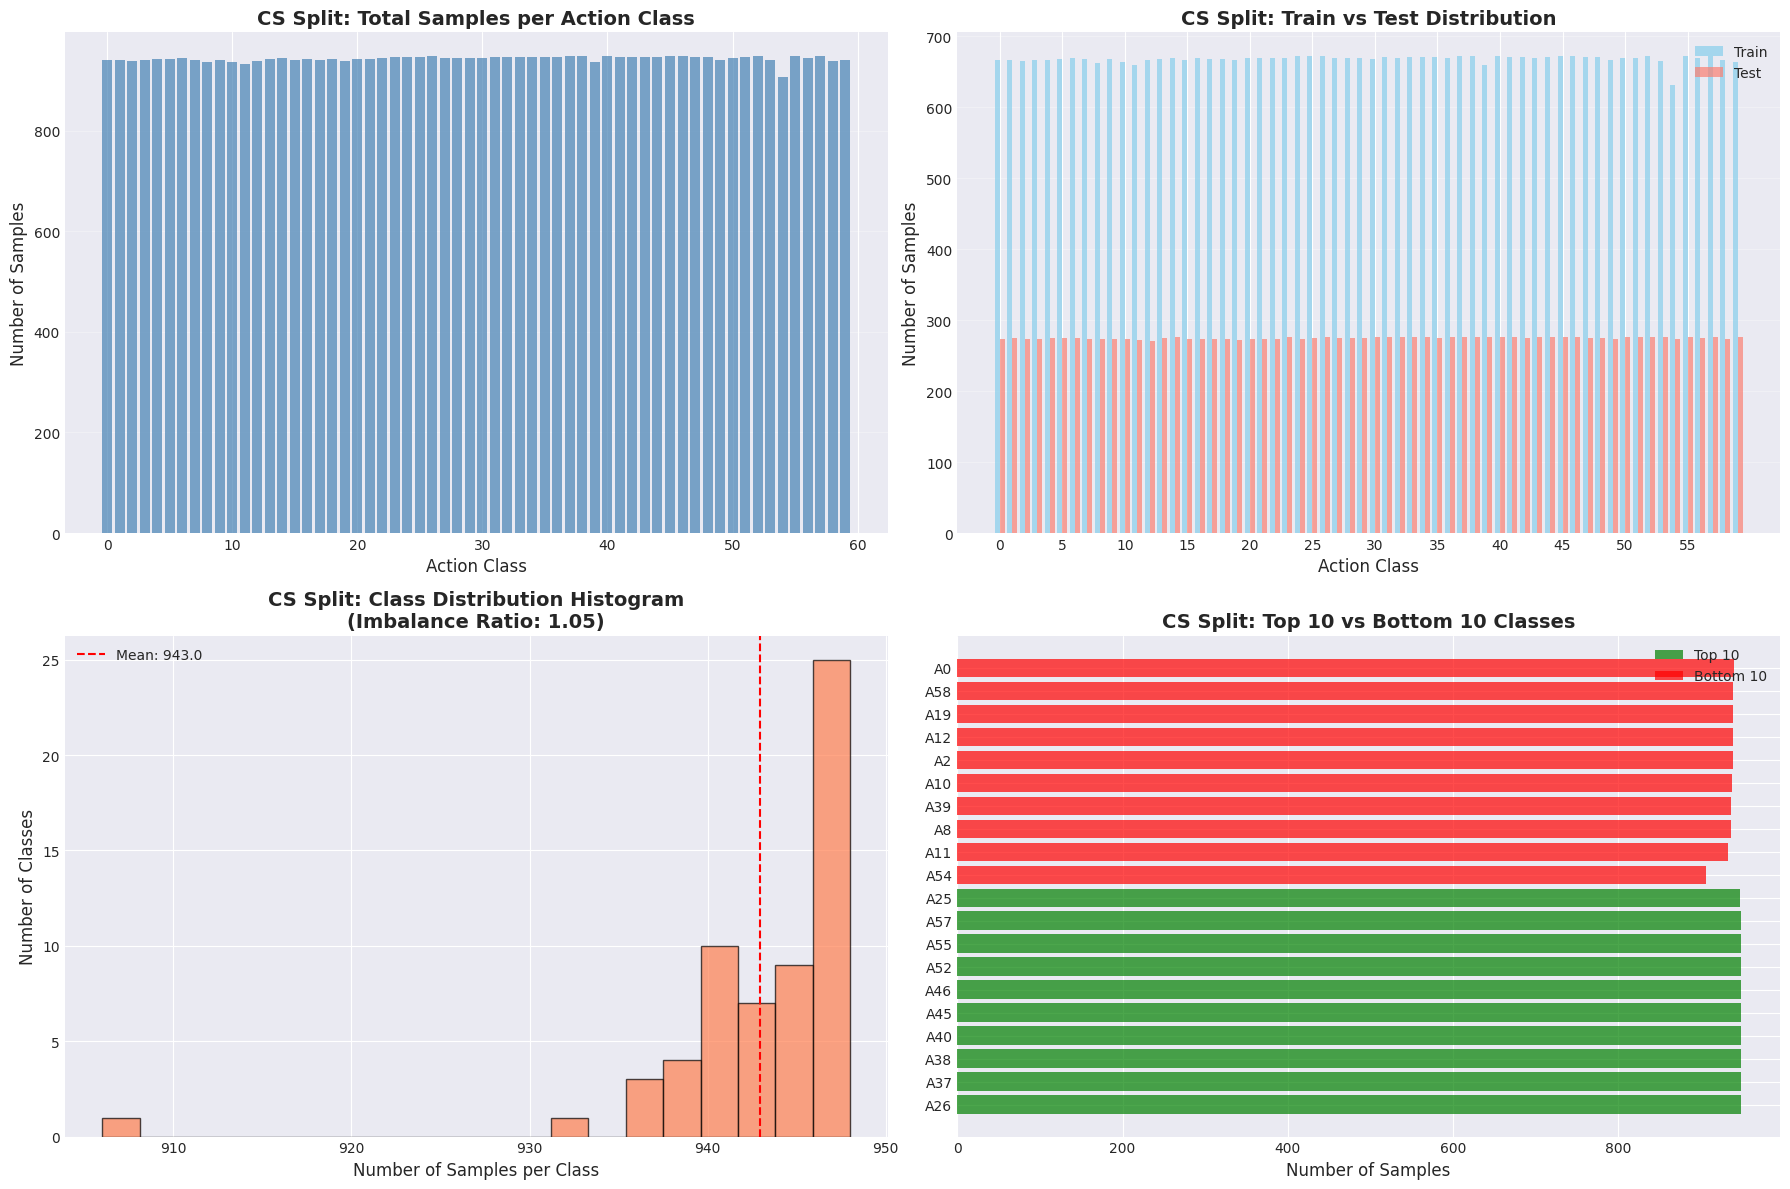


Class Imbalance Analysis:
  Min samples per class: 906
  Max samples per class: 948
  Mean samples per class: 943.0
  Std samples per class: 6.1
  Imbalance ratio: 1.05

✓ All 60 action classes have at least 1 sample


In [56]:
# Analyze action class distribution for CS split
cs_train_counts = Counter(cs_y_train)
cs_test_counts = Counter(cs_y_test)

# Create DataFrame
cs_action_dist = pd.DataFrame({
    'action': range(0, 60),
    'train': [cs_train_counts.get(i, 0) for i in range(0, 60)],
    'test': [cs_test_counts.get(i, 0) for i in range(0, 60)]
})
cs_action_dist['total'] = cs_action_dist['train'] + cs_action_dist['test']
cs_action_dist['train_pct'] = (cs_action_dist['train'] / cs_action_dist['total'] * 100).round(1)
cs_action_dist['test_pct'] = (cs_action_dist['test'] / cs_action_dist['total'] * 100).round(1)

print("Cross-Subject Split - Action Class Distribution:")
print(cs_action_dist.head(10))

# Visualize
fig, axes = plt.subplots(2, 2, figsize=(18, 12))

# Overall distribution
axes[0, 0].bar(cs_action_dist['action'], cs_action_dist['total'], alpha=0.7, color='steelblue')
axes[0, 0].set_title('CS Split: Total Samples per Action Class', fontsize=14, fontweight='bold')
axes[0, 0].set_xlabel('Action Class', fontsize=12)
axes[0, 0].set_ylabel('Number of Samples', fontsize=12)
axes[0, 0].grid(True, alpha=0.3, axis='y')

# Train vs Test
x_pos = np.arange(len(cs_action_dist))
axes[0, 1].bar(x_pos - 0.2, cs_action_dist['train'], 0.4, label='Train', alpha=0.7, color='skyblue')
axes[0, 1].bar(x_pos + 0.2, cs_action_dist['test'], 0.4, label='Test', alpha=0.7, color='salmon')
axes[0, 1].set_title('CS Split: Train vs Test Distribution', fontsize=14, fontweight='bold')
axes[0, 1].set_xlabel('Action Class', fontsize=12)
axes[0, 1].set_ylabel('Number of Samples', fontsize=12)
axes[0, 1].set_xticks(x_pos[::5])
axes[0, 1].set_xticklabels(cs_action_dist['action'][::5])
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3, axis='y')

# Class imbalance analysis
imbalance_ratio = cs_action_dist['total'].max() / cs_action_dist['total'].min()
axes[1, 0].hist(cs_action_dist['total'], bins=20, edgecolor='black', alpha=0.7, color='coral')
axes[1, 0].set_title(f'CS Split: Class Distribution Histogram\n(Imbalance Ratio: {imbalance_ratio:.2f})', fontsize=14, fontweight='bold')
axes[1, 0].set_xlabel('Number of Samples per Class', fontsize=12)
axes[1, 0].set_ylabel('Number of Classes', fontsize=12)
axes[1, 0].axvline(cs_action_dist['total'].mean(), color='r', linestyle='--', 
                    label=f'Mean: {cs_action_dist["total"].mean():.1f}')
axes[1, 0].legend()

# Top 10 and bottom 10 classes
top_10 = cs_action_dist.nlargest(10, 'total')
bottom_10 = cs_action_dist.nsmallest(10, 'total')
axes[1, 1].barh(range(10), top_10['total'].values, alpha=0.7, color='green', label='Top 10')
axes[1, 1].barh(range(10, 20), bottom_10['total'].values, alpha=0.7, color='red', label='Bottom 10')
axes[1, 1].set_yticks(range(20))
axes[1, 1].set_yticklabels([f'A{int(a)}' for a in list(top_10['action']) + list(bottom_10['action'])])
axes[1, 1].set_title('CS Split: Top 10 vs Bottom 10 Classes', fontsize=14, fontweight='bold')
axes[1, 1].set_xlabel('Number of Samples', fontsize=12)
axes[1, 1].legend()

plt.tight_layout()
plt.show()

print(f"\nClass Imbalance Analysis:")
print(f"  Min samples per class: {cs_action_dist['total'].min()}")
print(f"  Max samples per class: {cs_action_dist['total'].max()}")
print(f"  Mean samples per class: {cs_action_dist['total'].mean():.1f}")
print(f"  Std samples per class: {cs_action_dist['total'].std():.1f}")
print(f"  Imbalance ratio: {imbalance_ratio:.2f}")

# Check for classes with 0 samples
zero_sample_classes = cs_action_dist[cs_action_dist['total'] == 0]
if len(zero_sample_classes) > 0:
    print(f"\n⚠️  Classes with 0 samples: {list(zero_sample_classes['action'].values)}")
    print(f"   Total classes with 0 samples: {len(zero_sample_classes)}")
    print(f"\n   Details:")
    print(zero_sample_classes[['action', 'train', 'test', 'total']].to_string(index=False))
else:
    print(f"\n✓ All 60 action classes have at least 1 sample")

## 2. File Format & Data Schema

### 2.1 NPZ Structure

In [57]:
# Inspect data structure
print("NPZ File Structure:")
print("=" * 60)

print("\nArrays in NPZ file:")
for key in cs_data.keys():
    arr = cs_data[key]
    print(f"  {key}:")
    print(f"    Shape: {arr.shape}")
    print(f"    Dtype: {arr.dtype}")
    print(f"    Min: {arr.min():.4f}, Max: {arr.max():.4f}, Mean: {arr.mean():.4f}")

NPZ File Structure:

Arrays in NPZ file:
  x_train:
    Shape: (40091, 300, 150)
    Dtype: float32
    Min: -5.2898, Max: 5.1886, Mean: -0.0149
  y_train:
    Shape: (40091, 60)
    Dtype: float64
    Min: 0.0000, Max: 1.0000, Mean: 0.0167
  x_test:
    Shape: (16487, 300, 150)
    Dtype: float32
    Min: -5.0624, Max: 4.9507, Mean: -0.0166
  y_test:
    Shape: (16487, 60)
    Dtype: float64
    Min: 0.0000, Max: 1.0000, Mean: 0.0167


In [58]:
print("\n\nLabel Encoding:")
print(f"  y_train/y_test are one-hot encoded")
print(f"  Shape: {cs_data['y_train'].shape}")
print(f"  Number of classes: {cs_data['y_train'].shape[1]}")
print(f"  Example label (first sample): {cs_data['y_train'][0]}")
print(f"  Extracted class: {cs_y_train[0]}")



Label Encoding:
  y_train/y_test are one-hot encoded
  Shape: (40091, 60)
  Number of classes: 60
  Example label (first sample): [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
  Extracted class: 0


### 2.2 Sample Data Inspection

In [8]:
# Inspect a sample
sample_idx = 0
sample_data = cs_x_train_reshaped[sample_idx]  # Shape: (T, M, V, C)
sample_label = cs_y_train[sample_idx]

print(f"Sample {sample_idx} (Action Class {sample_label}):")
print("=" * 60)
print(f"\nData shape: {sample_data.shape}")
print(f"  T (frames): {sample_data.shape[0]}")
print(f"  M (persons): {sample_data.shape[1]}")
print(f"  V (joints): {sample_data.shape[2]}")
print(f"  C (coordinates): {sample_data.shape[3]}")

# Check for valid persons (non-zero data)
person_0_valid = np.any(sample_data[:, 0, :, :] != 0, axis=(1, 2))
person_1_valid = np.any(sample_data[:, 1, :, :] != 0, axis=(1, 2))

print(f"\nValid frames:")
print(f"  Person 0: {np.sum(person_0_valid)} / {len(person_0_valid)} frames")
print(f"  Person 1: {np.sum(person_1_valid)} / {len(person_1_valid)} frames")

# Show first frame
print(f"\nFirst frame (Person 0):")
print(f"  Shape: {sample_data[0, 0].shape}")
print(f"  First 5 joints: {sample_data[0, 0, :5, :]}")

# Check coordinate ranges
all_coords = sample_data[sample_data != 0]
print(f"\nCoordinate statistics (non-zero):")
print(f"  Min: {all_coords.min():.4f}")
print(f"  Max: {all_coords.max():.4f}")
print(f"  Mean: {all_coords.mean():.4f}")
print(f"  Std: {all_coords.std():.4f}")

Sample 0 (Action Class 0):

Data shape: (300, 2, 25, 3)
  T (frames): 300
  M (persons): 2
  V (joints): 25
  C (coordinates): 3

Valid frames:
  Person 0: 103 / 300 frames
  Person 1: 0 / 300 frames

First frame (Person 0):
  Shape: (25, 3)
  First 5 joints: [[-0.0142139  -0.2600664   0.07078004]
 [ 0.          0.          0.        ]
 [ 0.0134507   0.2550613  -0.08086991]
 [-0.0194785   0.3752589  -0.13277197]
 [-0.12139881  0.1784915   0.00219512]]

Coordinate statistics (non-zero):
  Min: -0.9600
  Max: 0.4120
  Mean: -0.0643
  Std: 0.2636


## 3. Temporal Characteristics

### 3.1 Sequence Length Analysis

Sequence Length Analysis (CS Split):

Train Set:
  Min length: 32
  Max length: 300
  Mean length: 82.8
  Median length: 75.0
  Std length: 31.7

Test Set:
  Min length: 33
  Max length: 300
  Mean length: 88.2
  Median length: 80.0
  Std length: 33.1


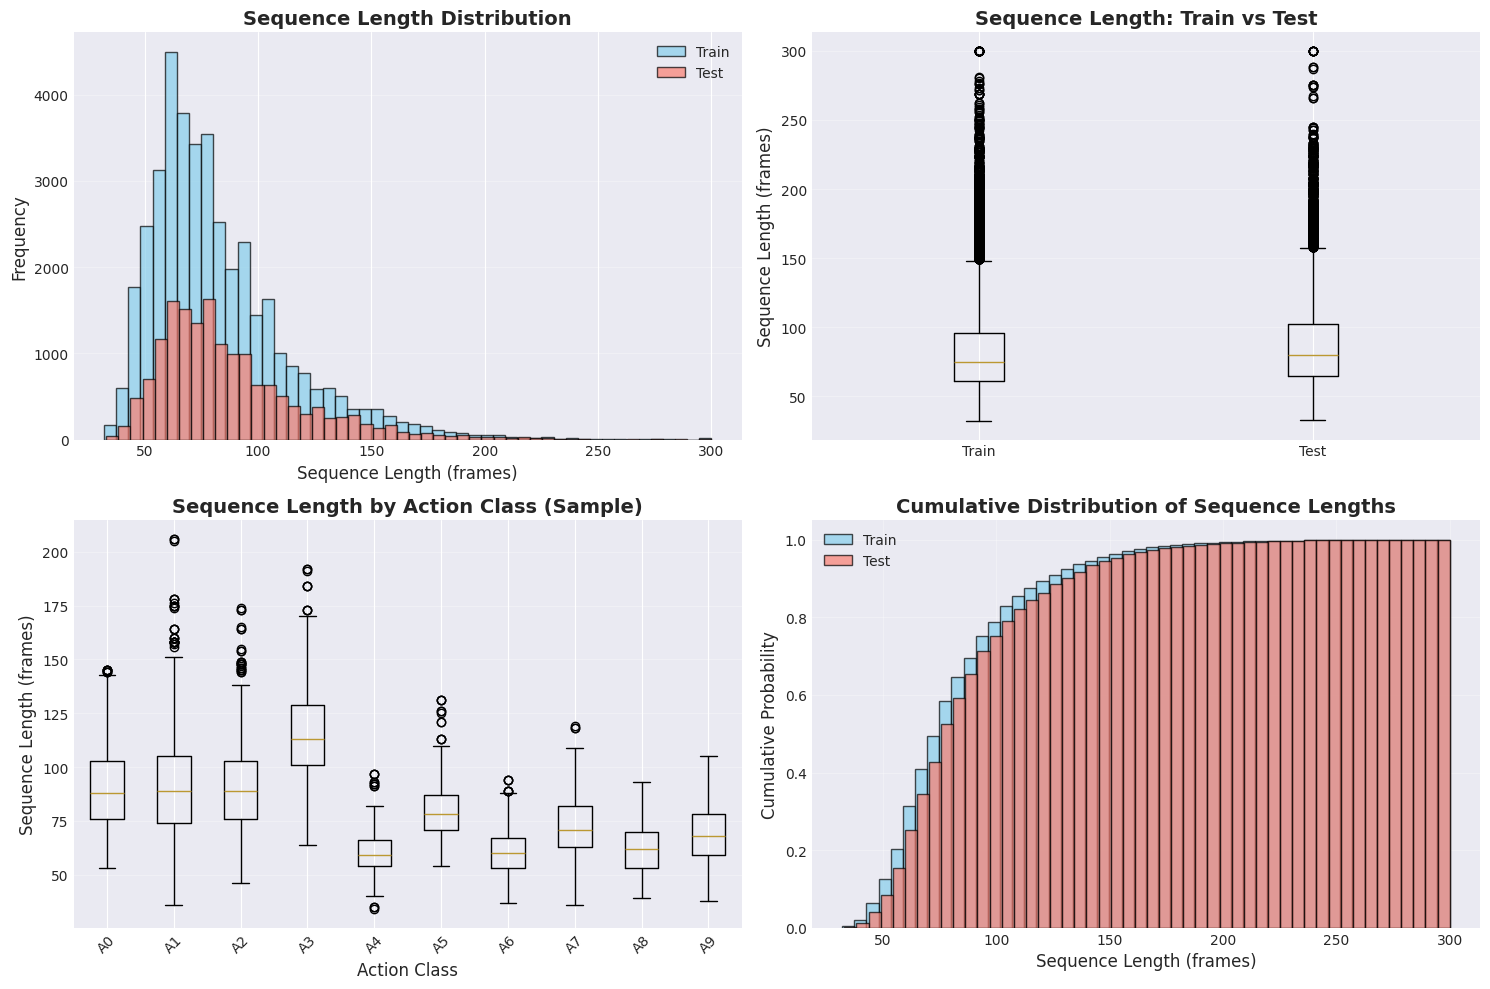

In [9]:
# Analyze sequence lengths
def compute_valid_lengths(data_reshaped):
    """Compute valid sequence lengths (non-zero frames)"""
    lengths = []
    for i in range(data_reshaped.shape[0]):
        sample = data_reshaped[i]  # (T, M, V, C)
        # Check if frame has any non-zero data across all persons and joints
        valid_frames = np.any(sample != 0, axis=(1, 2, 3))
        lengths.append(np.sum(valid_frames))
    return np.array(lengths)

# Compute lengths for CS train
cs_train_lengths = compute_valid_lengths(cs_x_train_reshaped)

# Reshape CS test data
cs_x_test_reshaped = cs_data['x_test'].reshape(
    cs_data['x_test'].shape[0], 
    cs_data['x_test'].shape[1], 
    2, 25, 3
)
cs_test_lengths = compute_valid_lengths(cs_x_test_reshaped)

print("Sequence Length Analysis (CS Split):")
print("=" * 60)
print(f"\nTrain Set:")
print(f"  Min length: {cs_train_lengths.min()}")
print(f"  Max length: {cs_train_lengths.max()}")
print(f"  Mean length: {cs_train_lengths.mean():.1f}")
print(f"  Median length: {np.median(cs_train_lengths):.1f}")
print(f"  Std length: {cs_train_lengths.std():.1f}")

print(f"\nTest Set:")
print(f"  Min length: {cs_test_lengths.min()}")
print(f"  Max length: {cs_test_lengths.max()}")
print(f"  Mean length: {cs_test_lengths.mean():.1f}")
print(f"  Median length: {np.median(cs_test_lengths):.1f}")
print(f"  Std length: {cs_test_lengths.std():.1f}")

# Visualize
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Histogram
axes[0, 0].hist(cs_train_lengths, bins=50, alpha=0.7, label='Train', color='skyblue', edgecolor='black')
axes[0, 0].hist(cs_test_lengths, bins=50, alpha=0.7, label='Test', color='salmon', edgecolor='black')
axes[0, 0].set_title('Sequence Length Distribution', fontsize=14, fontweight='bold')
axes[0, 0].set_xlabel('Sequence Length (frames)', fontsize=12)
axes[0, 0].set_ylabel('Frequency', fontsize=12)
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3, axis='y')

# Box plot
axes[0, 1].boxplot([cs_train_lengths, cs_test_lengths], labels=['Train', 'Test'])
axes[0, 1].set_title('Sequence Length: Train vs Test', fontsize=14, fontweight='bold')
axes[0, 1].set_ylabel('Sequence Length (frames)', fontsize=12)
axes[0, 1].grid(True, alpha=0.3, axis='y')

# Sequence length by action class (sample)
df_seq = pd.DataFrame({
    'action': cs_y_train,
    'length': cs_train_lengths
})
sample_actions = sorted(df_seq['action'].unique())[:10]
df_seq_sample = df_seq[df_seq['action'].isin(sample_actions)]

axes[1, 0].boxplot([df_seq_sample[df_seq_sample['action'] == a]['length'].values 
                    for a in sample_actions], labels=[f'A{a}' for a in sample_actions])
axes[1, 0].set_title('Sequence Length by Action Class (Sample)', fontsize=14, fontweight='bold')
axes[1, 0].set_xlabel('Action Class', fontsize=12)
axes[1, 0].set_ylabel('Sequence Length (frames)', fontsize=12)
axes[1, 0].tick_params(axis='x', rotation=45)
axes[1, 0].grid(True, alpha=0.3, axis='y')

# Cumulative distribution
axes[1, 1].hist(cs_train_lengths, bins=50, cumulative=True, density=True, 
                 alpha=0.7, label='Train', color='skyblue', edgecolor='black')
axes[1, 1].hist(cs_test_lengths, bins=50, cumulative=True, density=True, 
                 alpha=0.7, label='Test', color='salmon', edgecolor='black')
axes[1, 1].set_title('Cumulative Distribution of Sequence Lengths', fontsize=14, fontweight='bold')
axes[1, 1].set_xlabel('Sequence Length (frames)', fontsize=12)
axes[1, 1].set_ylabel('Cumulative Probability', fontsize=12)
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

### 3.2 Person Count Analysis

Person Count Analysis (CS Split):

Train Set:
  1 person: 32574 (81.3%)
  2 persons: 7517 (18.7%)

Test Set:
  1 person: 13405 (81.3%)
  2 persons: 3082 (18.7%)


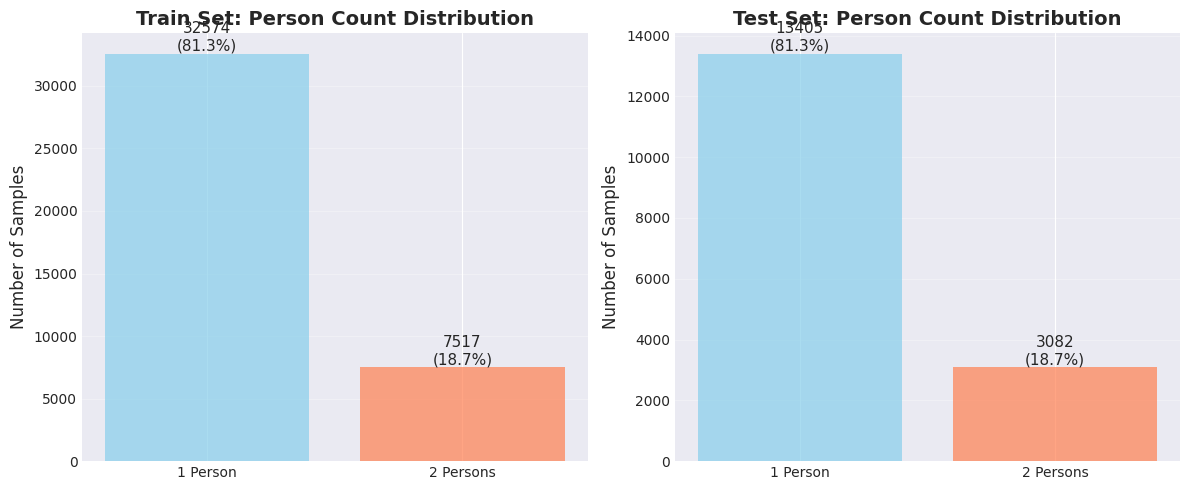

In [10]:
# Analyze person count per sample
def count_persons(data_reshaped):
    """Count number of valid persons per sample"""
    person_counts = []
    for i in range(data_reshaped.shape[0]):
        sample = data_reshaped[i]  # (T, M, V, C)
        # Check if person has any non-zero data
        person_0_valid = np.any(sample[:, 0, :, :] != 0)
        person_1_valid = np.any(sample[:, 1, :, :] != 0)
        count = int(person_0_valid) + int(person_1_valid)
        person_counts.append(count)
    return np.array(person_counts)

cs_train_person_counts = count_persons(cs_x_train_reshaped)
cs_test_person_counts = count_persons(cs_x_test_reshaped)

print("Person Count Analysis (CS Split):")
print("=" * 60)
print(f"\nTrain Set:")
print(f"  1 person: {np.sum(cs_train_person_counts == 1)} ({np.sum(cs_train_person_counts == 1)/len(cs_train_person_counts)*100:.1f}%)")
print(f"  2 persons: {np.sum(cs_train_person_counts == 2)} ({np.sum(cs_train_person_counts == 2)/len(cs_train_person_counts)*100:.1f}%)")

print(f"\nTest Set:")
print(f"  1 person: {np.sum(cs_test_person_counts == 1)} ({np.sum(cs_test_person_counts == 1)/len(cs_test_person_counts)*100:.1f}%)")
print(f"  2 persons: {np.sum(cs_test_person_counts == 2)} ({np.sum(cs_test_person_counts == 2)/len(cs_test_person_counts)*100:.1f}%)")

# Visualize
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Train set
train_counts = [np.sum(cs_train_person_counts == 1), np.sum(cs_train_person_counts == 2)]
axes[0].bar(['1 Person', '2 Persons'], train_counts, alpha=0.7, color=['skyblue', 'coral'])
axes[0].set_title('Train Set: Person Count Distribution', fontsize=14, fontweight='bold')
axes[0].set_ylabel('Number of Samples', fontsize=12)
axes[0].grid(True, alpha=0.3, axis='y')
for i, v in enumerate(train_counts):
    axes[0].text(i, v, f'{v}\n({v/sum(train_counts)*100:.1f}%)', 
                 ha='center', va='bottom', fontsize=11)

# Test set
test_counts = [np.sum(cs_test_person_counts == 1), np.sum(cs_test_person_counts == 2)]
axes[1].bar(['1 Person', '2 Persons'], test_counts, alpha=0.7, color=['skyblue', 'coral'])
axes[1].set_title('Test Set: Person Count Distribution', fontsize=14, fontweight='bold')
axes[1].set_ylabel('Number of Samples', fontsize=12)
axes[1].grid(True, alpha=0.3, axis='y')
for i, v in enumerate(test_counts):
    axes[1].text(i, v, f'{v}\n({v/sum(test_counts)*100:.1f}%)', 
                 ha='center', va='bottom', fontsize=11)

plt.tight_layout()
plt.show()

## 4. Spatial (Skeleton) Characteristics

### 4.1 Skeleton Structure

In [11]:
# NTU60 bone pairs (from feeders/bone_pairs.py)
ntu_bone_pairs = [
    (1, 2), (2, 21), (3, 21), (4, 3), (5, 21), (6, 5),
    (7, 6), (8, 7), (9, 21), (10, 9), (11, 10), (12, 11),
    (13, 1), (14, 13), (15, 14), (16, 15), (17, 1), (18, 17),
    (19, 18), (20, 19), (22, 23), (21, 21), (23, 8), (24, 25), (25, 12)
]

print("NTU60 Skeleton Structure:")
print("=" * 60)
print(f"\nTotal joints: 25")
print(f"Total bone pairs: {len(ntu_bone_pairs)}")
print(f"\nBone pairs (child, parent):")
for i, (child, parent) in enumerate(ntu_bone_pairs, 1):
    print(f"  {i:2d}. Joint {child:2d} -> Joint {parent:2d}")

NTU60 Skeleton Structure:

Total joints: 25
Total bone pairs: 25

Bone pairs (child, parent):
   1. Joint  1 -> Joint  2
   2. Joint  2 -> Joint 21
   3. Joint  3 -> Joint 21
   4. Joint  4 -> Joint  3
   5. Joint  5 -> Joint 21
   6. Joint  6 -> Joint  5
   7. Joint  7 -> Joint  6
   8. Joint  8 -> Joint  7
   9. Joint  9 -> Joint 21
  10. Joint 10 -> Joint  9
  11. Joint 11 -> Joint 10
  12. Joint 12 -> Joint 11
  13. Joint 13 -> Joint  1
  14. Joint 14 -> Joint 13
  15. Joint 15 -> Joint 14
  16. Joint 16 -> Joint 15
  17. Joint 17 -> Joint  1
  18. Joint 18 -> Joint 17
  19. Joint 19 -> Joint 18
  20. Joint 20 -> Joint 19
  21. Joint 22 -> Joint 23
  22. Joint 21 -> Joint 21
  23. Joint 23 -> Joint  8
  24. Joint 24 -> Joint 25
  25. Joint 25 -> Joint 12


### 4.2 Joint Coordinate Analysis

In [42]:
def analyze_joint_coordinates(data_reshaped, max_samples=1000):
    """
    Analyze joint coordinate statistics across multiple samples.
    
    This function computes statistical properties (mean, std, range) for each joint's
    X, Y, Z coordinates across a subset of samples from the NTU60 dataset.
    
    IMPORTANT: NTU60 data may be centered/normalized, so zero coordinates are VALID
    (they represent actual skeleton positions, not missing data). Missing data is
    represented as entire persons or frames being all zeros, not individual zero coordinates.
    
    Args:
        data_reshaped: numpy array of shape (N, T, M, V, C) where:
            - N: number of samples
            - T: temporal frames (sequence length)
            - M: maximum persons (2)
            - V: vertices/joints (25)
            - C: coordinates (3: X, Y, Z)
        max_samples: maximum number of samples to analyze (default: 1000)
    
    Returns:
        all_coords_array: numpy array of shape (N_total, V, C) containing all valid
                          joint coordinates across samples, or None if no valid data found
        df_joint: pandas DataFrame with per-joint statistics including:
            - joint: joint index (0-24)
            - mean_x, mean_y, mean_z: mean coordinate values
            - std_x, std_y, std_z: standard deviation of coordinates
            - range_x, range_y, range_z: coordinate ranges (max - min)
            Returns None if no valid data found
    """
    # Step 1: Randomly sample a subset of data for analysis
    # This reduces computation time while maintaining statistical representativeness
    sample_indices = np.random.choice(
        data_reshaped.shape[0], 
        min(max_samples, data_reshaped.shape[0]), 
        replace=False
    )
    # print('analyze_joint_coordinates > sample_indices', sample_indices)
    # sample_indices = [100]  # Debug: use single sample for testing
    
    # Step 2: Collect all valid joint coordinates from sampled data
    # Note: We only filter out missing persons (all zeros), not individual zero coordinates
    all_coords = []
    for idx in sample_indices:
        # Extract one sample: shape (T, M, V, C)
        # T = frames, M = persons, V = joints, C = coordinates
        sample = data_reshaped[idx]  # (T, M, V, C)
        sample_shape = sample.shape
        print('analyze_joint_coordinates > sample_shape', sample_shape)
        
        # Step 2a: Process each person separately to filter out missing persons
        # A missing person has all zeros across all frames, joints, and coordinates
        valid_person_coords = []
        for person_idx in range(sample.shape[1]):  # Iterate over M (persons)
            person_data = sample[:, person_idx, :, :]  # (T, V, C)
            
            # Check if this person is valid (has at least some non-zero data)
            # Missing person = all zeros across all frames, joints, and coordinates
            if np.any(person_data != 0):  # Person is valid if any coordinate is non-zero
                # Reshape to (T*V, C) to flatten frames and joints
                person_coords_flat = person_data.reshape(-1, 3)  # (T*V, C)
                valid_person_coords.append(person_coords_flat)
        
        # Step 2b: Combine all valid persons' coordinates
        # If no valid persons found, skip this sample
        if len(valid_person_coords) > 0:
            # Concatenate all valid persons: shape (T*V*M_valid, C)
            sample_coords = np.concatenate(valid_person_coords, axis=0)
            print('analyze_joint_coordinates > sample_coords', sample_coords.shape)
            
            # Reshape back to preserve joint structure: (N_frames*M_valid, V, C)
            # But we need to track which joint is which, so we'll reshape differently
            # Actually, let's keep it flat for now and reshape properly later
            all_coords.append(sample_coords)
    
    # Step 3: Handle edge case - return None if no valid data found
    if len(all_coords) == 0:
        return None, None
    
    # Step 4: For proper per-joint analysis, we need to preserve joint structure
    # Let's collect coordinates per joint instead of flattening everything
    # This requires a different approach - collect per joint across all samples
    joint_coords_dict = {i: [] for i in range(25)}  # Store coordinates per joint
    
    for idx in sample_indices:
        sample = data_reshaped[idx]  # (T, M, V, C)
        
        # Process each person separately
        for person_idx in range(sample.shape[1]):
            person_data = sample[:, person_idx, :, :]  # (T, V, C)
            
            # Check if person is valid (not all zeros)
            if np.any(person_data != 0):
                # Extract coordinates for each joint
                for joint_idx in range(25):
                    joint_coords = person_data[:, joint_idx, :]  # (T, C)
                    # Append all frames for this joint
                    joint_coords_dict[joint_idx].append(joint_coords)
    
    # Step 5: Concatenate coordinates per joint and compute statistics
    joint_stats = []
    all_coords_list = []
    
    for joint_idx in range(25):
        if len(joint_coords_dict[joint_idx]) > 0:
            # Concatenate all frames from all samples for this joint
            joint_coords = np.concatenate(joint_coords_dict[joint_idx], axis=0)  # (N_total, C)
            all_coords_list.append(joint_coords)
            
            # Compute statistics (including zero coordinates - they're valid!)
            # No need to filter zeros since they represent valid skeleton positions
            joint_stats.append({
                'joint': joint_idx,  # Joint index (0-24)
                'mean_x': joint_coords[:, 0].mean(),  # Mean X coordinate (may include zeros)
                'mean_y': joint_coords[:, 1].mean(),  # Mean Y coordinate (may include zeros)
                'mean_z': joint_coords[:, 2].mean(),  # Mean Z coordinate (may include zeros)
                'std_x': joint_coords[:, 0].std(),    # Standard deviation of X
                'std_y': joint_coords[:, 1].std(),    # Standard deviation of Y
                'std_z': joint_coords[:, 2].std(),    # Standard deviation of Z
                'range_x': joint_coords[:, 0].max() - joint_coords[:, 0].min(),  # X range
                'range_y': joint_coords[:, 1].max() - joint_coords[:, 1].min(),  # Y range
                'range_z': joint_coords[:, 2].max() - joint_coords[:, 2].min(),  # Z range
            })
    
    # Step 6: Create combined array for overall statistics
    # Stack all joint coordinates: shape (N_total, V, C) where V=25
    if len(all_coords_list) > 0:
        # Pad missing joints with zeros if needed
        while len(all_coords_list) < 25:
            all_coords_list.append(np.zeros((0, 3)))  # Empty array for missing joints
        
        # Find max length to pad
        max_len = max(len(coords) for coords in all_coords_list) if all_coords_list else 0
        
        # Pad and stack: create array of shape (max_len, 25, 3)
        # Actually, better approach: just concatenate all and note the joint indices
        # For simplicity, return a flattened version for overall stats
        all_coords_array = np.concatenate(all_coords_list, axis=0)  # (N_total, C)
        print('analyze_joint_coordinates > all_coords_array (flattened)', all_coords_array.shape)
    else:
        all_coords_array = None
    
    # Step 7: Return results
    # all_coords_array: flattened coordinates (for overall statistics)
    # df_joint: DataFrame with per-joint statistics (for detailed analysis)
    return all_coords_array, pd.DataFrame(joint_stats)


In [43]:
# test function
coords_array, df_joint = analyze_joint_coordinates(cs_x_train_reshaped, max_samples=1)

analyze_joint_coordinates > sample_shape (300, 2, 25, 3)
analyze_joint_coordinates > sample_coords (15000, 3)
analyze_joint_coordinates > all_coords_array (flattened) (15000, 3)


Analyzing joint coordinates...
analyze_joint_coordinates > sample_shape (300, 2, 25, 3)
analyze_joint_coordinates > sample_coords (7500, 3)
analyze_joint_coordinates > sample_shape (300, 2, 25, 3)
analyze_joint_coordinates > sample_coords (7500, 3)
analyze_joint_coordinates > sample_shape (300, 2, 25, 3)
analyze_joint_coordinates > sample_coords (15000, 3)
analyze_joint_coordinates > sample_shape (300, 2, 25, 3)
analyze_joint_coordinates > sample_coords (7500, 3)
analyze_joint_coordinates > sample_shape (300, 2, 25, 3)
analyze_joint_coordinates > sample_coords (7500, 3)
analyze_joint_coordinates > sample_shape (300, 2, 25, 3)
analyze_joint_coordinates > sample_coords (7500, 3)
analyze_joint_coordinates > sample_shape (300, 2, 25, 3)
analyze_joint_coordinates > sample_coords (7500, 3)
analyze_joint_coordinates > sample_shape (300, 2, 25, 3)
analyze_joint_coordinates > sample_coords (7500, 3)
analyze_joint_coordinates > sample_shape (300, 2, 25, 3)
analyze_joint_coordinates > sample_coor

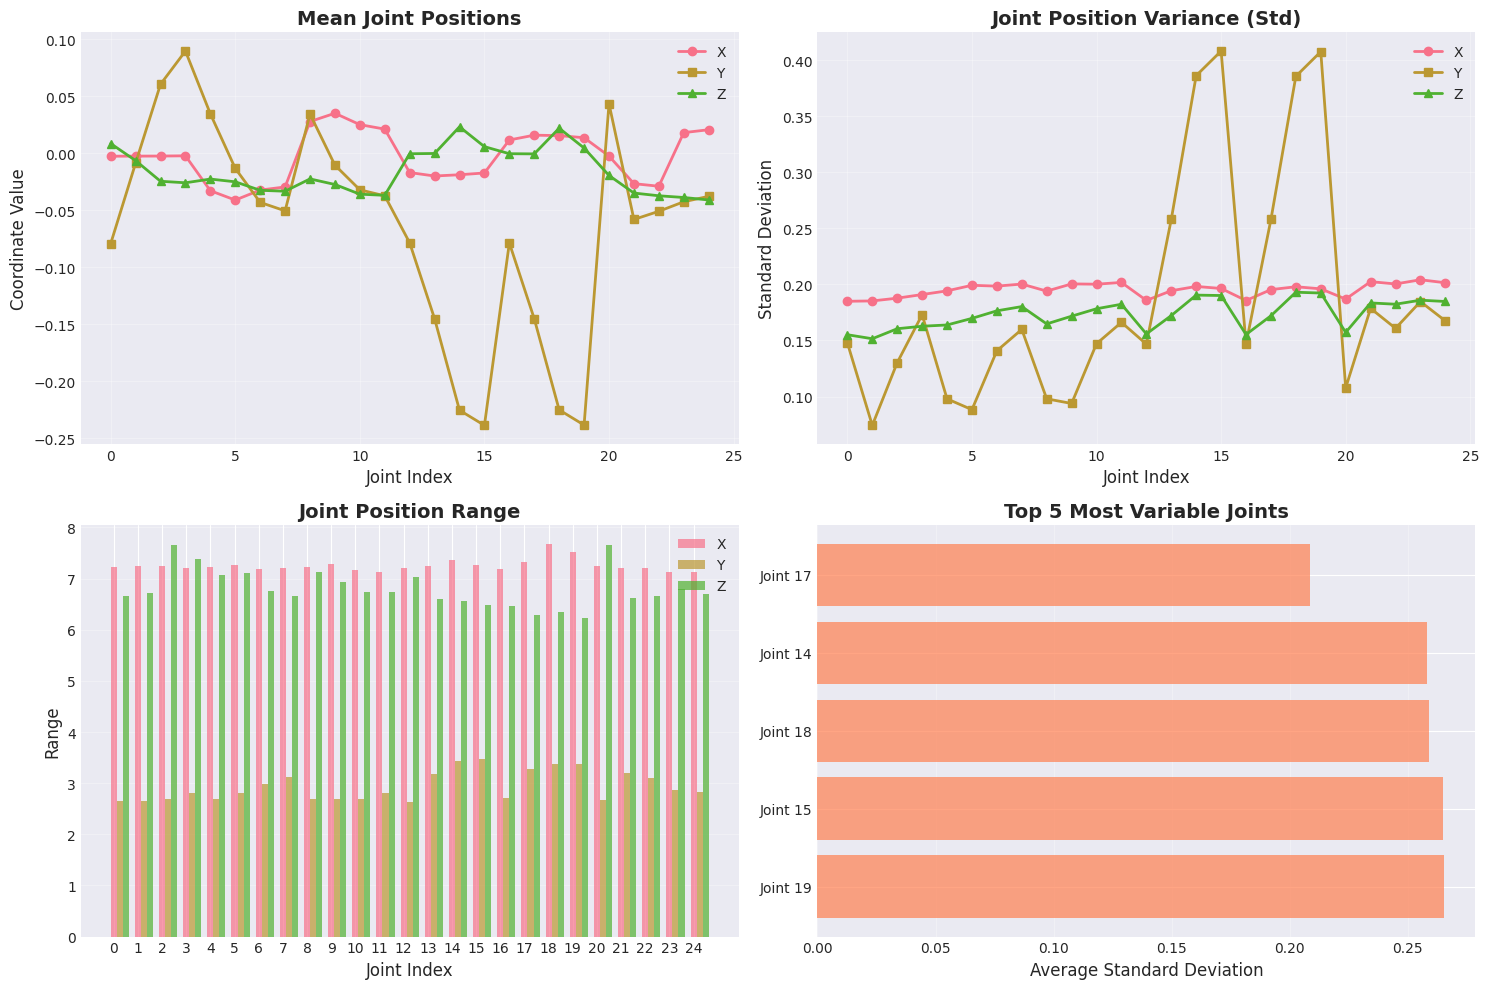


Most variable joints: [19, 15, 18, 14, 17]
Least variable joints: [1, 20, 4, 8, 5]


In [44]:
# Analyze joint coordinates across samples

print("Analyzing joint coordinates...")
coords_array, df_joint = analyze_joint_coordinates(cs_x_train_reshaped, max_samples=2000)

if coords_array is not None:
    print("\nOverall Coordinate Statistics:")
    # Filter zeros
    non_zero_coords = coords_array[coords_array != 0]
    print(f"  Shape: {coords_array.shape}")
    print(f"  Non-zero coordinates: {len(non_zero_coords)}")
    print(f"  Min (X, Y, Z): ({non_zero_coords.min():.2f}, {non_zero_coords.min():.2f}, {non_zero_coords.min():.2f})")
    print(f"  Max (X, Y, Z): ({non_zero_coords.max():.2f}, {non_zero_coords.max():.2f}, {non_zero_coords.max():.2f})")
    print(f"  Mean (X, Y, Z): ({non_zero_coords.mean():.2f}, {non_zero_coords.mean():.2f}, {non_zero_coords.mean():.2f})")
    print(f"  Std (X, Y, Z): ({non_zero_coords.std():.2f}, {non_zero_coords.std():.2f}, {non_zero_coords.std():.2f})")

    if df_joint is not None and len(df_joint) > 0:
        print("\nPer-Joint Average Statistics:")
        print(df_joint.head(10))

        # Visualize
        fig, axes = plt.subplots(2, 2, figsize=(15, 10))

        joints = df_joint['joint'].values
        
        # Mean position per joint
        axes[0, 0].plot(joints, df_joint['mean_x'], 'o-', label='X', linewidth=2, markersize=6)
        axes[0, 0].plot(joints, df_joint['mean_y'], 's-', label='Y', linewidth=2, markersize=6)
        axes[0, 0].plot(joints, df_joint['mean_z'], '^-', label='Z', linewidth=2, markersize=6)
        axes[0, 0].set_title('Mean Joint Positions', fontsize=14, fontweight='bold')
        axes[0, 0].set_xlabel('Joint Index', fontsize=12)
        axes[0, 0].set_ylabel('Coordinate Value', fontsize=12)
        axes[0, 0].legend()
        axes[0, 0].grid(True, alpha=0.3)

        # Variance per joint
        axes[0, 1].plot(joints, df_joint['std_x'], 'o-', label='X', linewidth=2, markersize=6)
        axes[0, 1].plot(joints, df_joint['std_y'], 's-', label='Y', linewidth=2, markersize=6)
        axes[0, 1].plot(joints, df_joint['std_z'], '^-', label='Z', linewidth=2, markersize=6)
        axes[0, 1].set_title('Joint Position Variance (Std)', fontsize=14, fontweight='bold')
        axes[0, 1].set_xlabel('Joint Index', fontsize=12)
        axes[0, 1].set_ylabel('Standard Deviation', fontsize=12)
        axes[0, 1].legend()
        axes[0, 1].grid(True, alpha=0.3)

        # Range per joint
        axes[1, 0].bar(joints, df_joint['range_x'], alpha=0.7, label='X', width=0.25)
        axes[1, 0].bar(joints + 0.25, df_joint['range_y'], alpha=0.7, label='Y', width=0.25)
        axes[1, 0].bar(joints + 0.5, df_joint['range_z'], alpha=0.7, label='Z', width=0.25)
        axes[1, 0].set_title('Joint Position Range', fontsize=14, fontweight='bold')
        axes[1, 0].set_xlabel('Joint Index', fontsize=12)
        axes[1, 0].set_ylabel('Range', fontsize=12)
        axes[1, 0].legend()
        axes[1, 0].set_xticks(joints)
        axes[1, 0].grid(True, alpha=0.3, axis='y')

        # Most/least variable joints
        total_variance = df_joint[['std_x', 'std_y', 'std_z']].mean(axis=1)
        most_variable = total_variance.nlargest(5).index.tolist()
        least_variable = total_variance.nsmallest(5).index.tolist()

        axes[1, 1].barh(range(5), total_variance.iloc[most_variable].values, color='coral', alpha=0.7)
        axes[1, 1].set_yticks(range(5))
        axes[1, 1].set_yticklabels([f'Joint {int(df_joint.iloc[i]["joint"])}' for i in most_variable])
        axes[1, 1].set_title('Top 5 Most Variable Joints', fontsize=14, fontweight='bold')
        axes[1, 1].set_xlabel('Average Standard Deviation', fontsize=12)
        axes[1, 1].grid(True, alpha=0.3, axis='x')

        plt.tight_layout()
        plt.show()

        print(f"\nMost variable joints: {[int(df_joint.iloc[i]['joint']) for i in most_variable]}")
        print(f"Least variable joints: {[int(df_joint.iloc[i]['joint']) for i in least_variable]}")

## 5. Motion Statistics

### 5.1 Velocity Analysis

In [45]:
# Compute velocity statistics
def compute_velocity_statistics(data_reshaped, labels, max_samples=500):
    """Compute velocity statistics"""
    sample_indices = np.random.choice(data_reshaped.shape[0], 
                                      min(max_samples, data_reshaped.shape[0]), 
                                      replace=False)
    
    velocity_stats = []
    
    for idx in sample_indices:
        sample = data_reshaped[idx]  # (T, M, V, C)
        label = labels[idx]
        
        # Process each person separately
        for person_idx in range(2):
            person_data = sample[:, person_idx, :, :]  # (T, V, C)
            
            # Check if person is valid
            if not np.any(person_data != 0):
                continue
            
            # Compute velocities (frame-to-frame differences)
            velocities = np.diff(person_data, axis=0)  # (T-1, V, C)
            velocity_magnitudes = np.linalg.norm(velocities, axis=2)  # (T-1, V)
            
            # Filter out zero velocities
            valid_velocities = velocity_magnitudes[velocity_magnitudes > 0]
            
            if len(valid_velocities) > 0:
                velocity_stats.append({
                    'sample': idx,
                    'action': label,
                    'person': person_idx,
                    'velocity_mean': valid_velocities.mean(),
                    'velocity_max': valid_velocities.max(),
                    'velocity_std': valid_velocities.std(),
                })
    
    return pd.DataFrame(velocity_stats)

In [46]:
# test function
df_velocity = compute_velocity_statistics(cs_x_train_reshaped, cs_y_train, max_samples=1)

Computing velocity statistics...

Velocity Statistics:
count    1174.000000
mean        0.029540
std         0.018462
min         0.007073
25%         0.019364
50%         0.025525
75%         0.034340
max         0.234191
Name: velocity_mean, dtype: float64


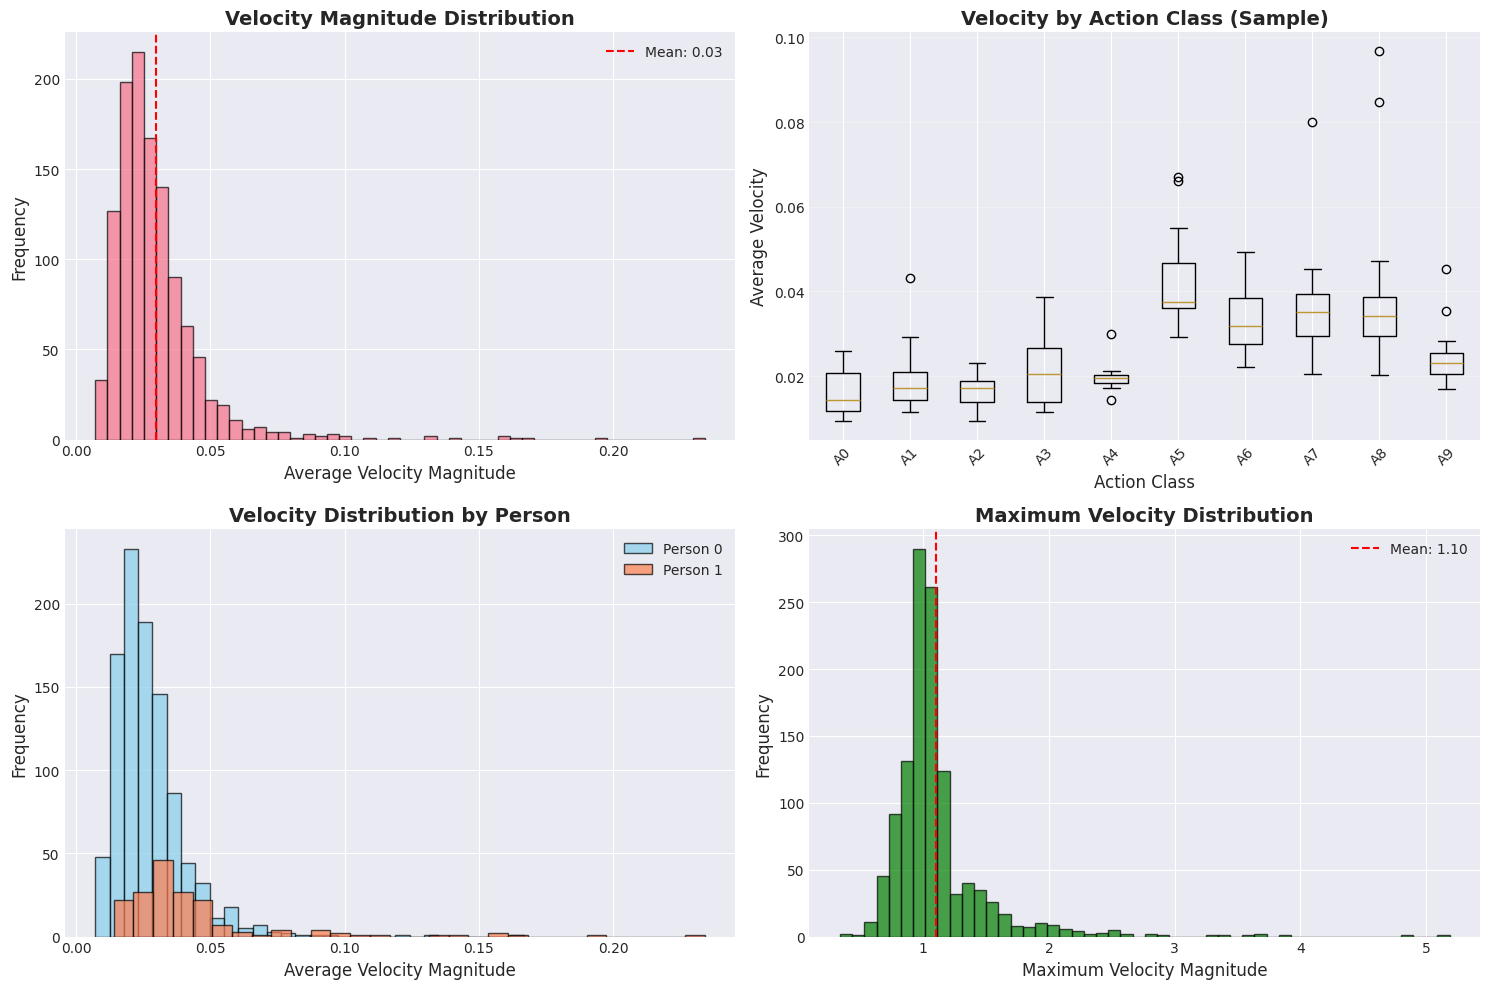

In [47]:
print("Computing velocity statistics...")
df_velocity = compute_velocity_statistics(cs_x_train_reshaped, cs_y_train, max_samples=1000)

if len(df_velocity) > 0:
    print("\nVelocity Statistics:")
    print(df_velocity['velocity_mean'].describe())

    # Visualize
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))

    # Velocity distribution
    axes[0, 0].hist(df_velocity['velocity_mean'], bins=50, edgecolor='black', alpha=0.7)
    axes[0, 0].set_title('Velocity Magnitude Distribution', fontsize=14, fontweight='bold')
    axes[0, 0].set_xlabel('Average Velocity Magnitude', fontsize=12)
    axes[0, 0].set_ylabel('Frequency', fontsize=12)
    axes[0, 0].axvline(df_velocity['velocity_mean'].mean(), color='r', linestyle='--', 
                        label=f'Mean: {df_velocity["velocity_mean"].mean():.2f}')
    axes[0, 0].legend()

    # Velocity by action (sample)
    sample_actions = sorted(df_velocity['action'].unique())[:10]
    df_velocity_sample = df_velocity[df_velocity['action'].isin(sample_actions)]
    
    if len(df_velocity_sample) > 0:
        axes[0, 1].boxplot([df_velocity_sample[df_velocity_sample['action'] == a]['velocity_mean'].values 
                            for a in sample_actions], 
                           labels=[f'A{a}' for a in sample_actions])
        axes[0, 1].set_title('Velocity by Action Class (Sample)', fontsize=14, fontweight='bold')
        axes[0, 1].set_xlabel('Action Class', fontsize=12)
        axes[0, 1].set_ylabel('Average Velocity', fontsize=12)
        axes[0, 1].tick_params(axis='x', rotation=45)
        axes[0, 1].grid(True, alpha=0.3, axis='y')

    # Velocity by person
    person_0_vel = df_velocity[df_velocity['person'] == 0]['velocity_mean']
    person_1_vel = df_velocity[df_velocity['person'] == 1]['velocity_mean']
    
    axes[1, 0].hist(person_0_vel, bins=30, alpha=0.7, label='Person 0', color='skyblue', edgecolor='black')
    axes[1, 0].hist(person_1_vel, bins=30, alpha=0.7, label='Person 1', color='coral', edgecolor='black')
    axes[1, 0].set_title('Velocity Distribution by Person', fontsize=14, fontweight='bold')
    axes[1, 0].set_xlabel('Average Velocity Magnitude', fontsize=12)
    axes[1, 0].set_ylabel('Frequency', fontsize=12)
    axes[1, 0].legend()

    # Max velocity distribution
    axes[1, 1].hist(df_velocity['velocity_max'], bins=50, edgecolor='black', alpha=0.7, color='green')
    axes[1, 1].set_title('Maximum Velocity Distribution', fontsize=14, fontweight='bold')
    axes[1, 1].set_xlabel('Maximum Velocity Magnitude', fontsize=12)
    axes[1, 1].set_ylabel('Frequency', fontsize=12)
    axes[1, 1].axvline(df_velocity['velocity_max'].mean(), color='r', linestyle='--', 
                        label=f'Mean: {df_velocity["velocity_max"].mean():.2f}')
    axes[1, 1].legend()

    plt.tight_layout()
    plt.show()

## 6. Missing / Noise Analysis

### 6.1 Missing Data Detection

Checking for missing data...

Missing Data Statistics:
             sample  num_frames   zero_coords  zero_coords_pct  zero_frames  \
count   2000.000000      2000.0   2000.000000      2000.000000  2000.000000   
mean   20315.320500       300.0  37922.971500        84.273270   217.939000   
std    11737.439147         0.0   2872.811133         6.384025    31.062835   
min       11.000000       300.0  14403.000000        32.006667    39.000000   
25%     9774.250000       300.0  36378.000000        80.840000   203.000000   
50%    20556.000000       300.0  38628.000000        85.840000   226.000000   
75%    30642.500000       300.0  40128.000000        89.173333   239.000000   
max    40083.000000       300.0  42453.000000        94.340000   266.000000   

       zero_persons  zero_joints  
count   2000.000000       2000.0  
mean       0.809500          0.0  
std        0.392794          0.0  
min        0.000000          0.0  
25%        1.000000          0.0  
50%        1.000000    

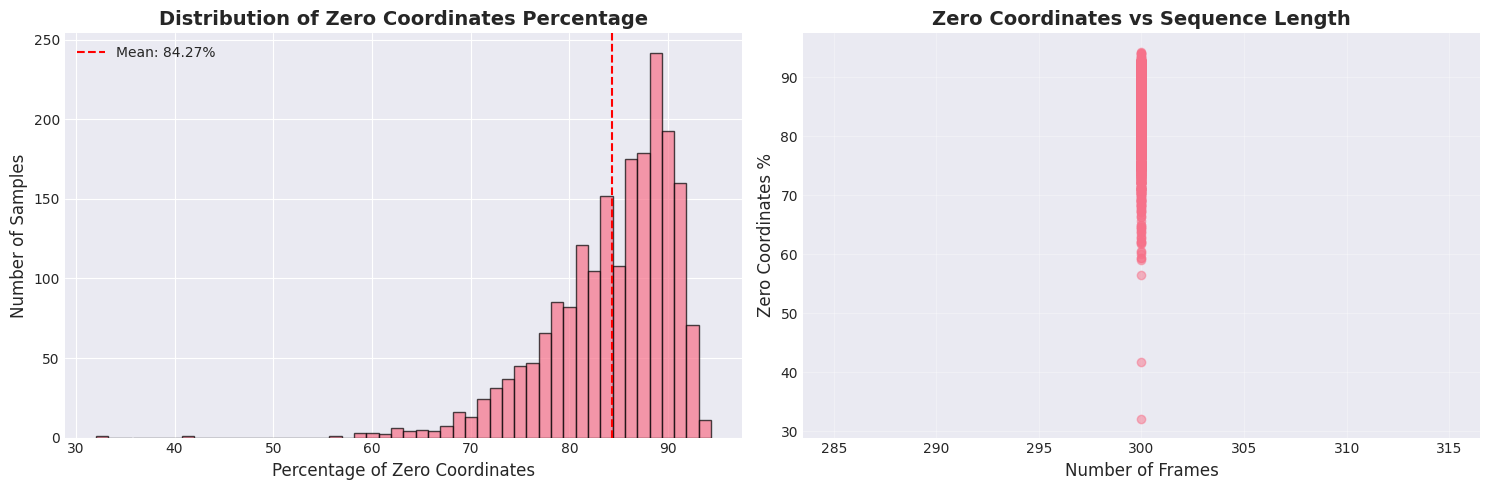


Data Quality Summary:
  Samples with zero coordinates: 2000
  Samples with zero frames: 2000
  Samples with zero persons: 1619
  Samples with zero joints: 0


In [49]:
# Check for missing data
def check_missing_data(data_reshaped, max_samples=1000):
    """Check for missing or invalid data"""
    sample_indices = np.random.choice(data_reshaped.shape[0], 
                                      min(max_samples, data_reshaped.shape[0]), 
                                      replace=False)
    
    missing_stats = []
    
    for idx in sample_indices:
        sample = data_reshaped[idx]  # (T, M, V, C)
        
        num_frames = sample.shape[0]
        num_persons = sample.shape[1]
        num_joints = sample.shape[2]
        total_coords = num_frames * num_persons * num_joints * 3
        
        zero_coords = np.sum(sample == 0)
        
        # Check for completely zero frames
        zero_frames = np.sum(np.all(sample == 0, axis=(1, 2, 3)))
        
        # Check for completely zero persons
        zero_persons = np.sum(np.all(sample == 0, axis=(0, 2, 3)))
        
        # Check for completely zero joints
        zero_joints = np.sum(np.all(sample == 0, axis=(0, 1, 3)))
        
        missing_stats.append({
            'sample': idx,
            'num_frames': num_frames,
            'zero_coords': zero_coords,
            'zero_coords_pct': zero_coords / total_coords * 100,
            'zero_frames': zero_frames,
            'zero_persons': zero_persons,
            'zero_joints': zero_joints,
        })
    
    return pd.DataFrame(missing_stats)

print("Checking for missing data...")
df_missing = check_missing_data(cs_x_train_reshaped, max_samples=2000)

print("\nMissing Data Statistics:")
print(df_missing.describe())

# Visualize
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

axes[0].hist(df_missing['zero_coords_pct'], bins=50, edgecolor='black', alpha=0.7)
axes[0].set_title('Distribution of Zero Coordinates Percentage', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Percentage of Zero Coordinates', fontsize=12)
axes[0].set_ylabel('Number of Samples', fontsize=12)
axes[0].axvline(df_missing['zero_coords_pct'].mean(), color='r', linestyle='--', 
                label=f'Mean: {df_missing["zero_coords_pct"].mean():.2f}%')
axes[0].legend()

axes[1].scatter(df_missing['num_frames'], df_missing['zero_coords_pct'], alpha=0.5)
axes[1].set_title('Zero Coordinates vs Sequence Length', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Number of Frames', fontsize=12)
axes[1].set_ylabel('Zero Coordinates %', fontsize=12)
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\nData Quality Summary:")
print(f"  Samples with zero coordinates: {len(df_missing[df_missing['zero_coords'] > 0])}")
print(f"  Samples with zero frames: {len(df_missing[df_missing['zero_frames'] > 0])}")
print(f"  Samples with zero persons: {len(df_missing[df_missing['zero_persons'] > 0])}")
print(f"  Samples with zero joints: {len(df_missing[df_missing['zero_joints'] > 0])}")

## 9. Key Observations & Modeling Implications

### Summary Statistics

In [52]:
# Create summary statistics table
summary_stats = {
    'Metric': [
        'Total Samples (CS)',
        'Train Samples (CS)',
        'Test Samples (CS)',
        'Action Classes',
        'Joints per Skeleton',
        'Persons per Sample',
        'Avg Sequence Length (Train)',
        'Min Sequence Length',
        'Max Sequence Length',
    ],
    'Value': [
        len(cs_y_train) + len(cs_y_test),
        len(cs_y_train),
        len(cs_y_test),
        60,
        25,
        '1-2',
        f"{cs_train_lengths.mean():.1f}",
        f"{cs_train_lengths.min()}",
        f"{cs_train_lengths.max()}",
    ]
}

df_summary = pd.DataFrame(summary_stats)
print("NTU60 Dataset Summary Statistics:")
print(df_summary.to_string(index=False))

NTU60 Dataset Summary Statistics:
                     Metric Value
         Total Samples (CS) 56578
         Train Samples (CS) 40091
          Test Samples (CS) 16487
             Action Classes    60
        Joints per Skeleton    25
         Persons per Sample   1-2
Avg Sequence Length (Train)  82.8
        Min Sequence Length    32
        Max Sequence Length   300


In [53]:
print("\n\nKey Observations:")
print("=" * 60)
print("1. Dataset Scale:")
print(f"   - Large-scale dataset with {len(cs_y_train) + len(cs_y_test)} total samples")
print(f"   - Train/Test split: {len(cs_y_train)}/{len(cs_y_test)}")

print("\n2. Temporal Characteristics:")
print(f"   - Variable sequence lengths: {cs_train_lengths.min()}-{cs_train_lengths.max()} frames")
print(f"   - Average length: {cs_train_lengths.mean():.1f} frames")
print(f"   - Significant variation in sequence duration across actions")

print("\n3. Spatial Characteristics:")
print(f"   - 25 joints per skeleton (vs 20 in NW-UCLA)")
print(f"   - Up to 2 persons per sample (vs 1 in NW-UCLA)")
print(f"   - 3D coordinates (X, Y, Z)")

print("\n4. Class Distribution:")
print(f"   - 60 action classes")
imbalance_ratio = cs_action_dist['total'].max() / cs_action_dist['total'].min()
print(f"   - Class imbalance ratio: {imbalance_ratio:.2f}")

print("\n5. Person Distribution:")
single_person_pct = np.sum(cs_train_person_counts == 1) / len(cs_train_person_counts) * 100
dual_person_pct = np.sum(cs_train_person_counts == 2) / len(cs_train_person_counts) * 100
print(f"   - Single person: {single_person_pct:.1f}%")
print(f"   - Dual person: {dual_person_pct:.1f}%")



Key Observations:
1. Dataset Scale:
   - Large-scale dataset with 56578 total samples
   - Train/Test split: 40091/16487

2. Temporal Characteristics:
   - Variable sequence lengths: 32-300 frames
   - Average length: 82.8 frames
   - Significant variation in sequence duration across actions

3. Spatial Characteristics:
   - 25 joints per skeleton (vs 20 in NW-UCLA)
   - Up to 2 persons per sample (vs 1 in NW-UCLA)
   - 3D coordinates (X, Y, Z)

4. Class Distribution:
   - 60 action classes
   - Class imbalance ratio: inf

5. Person Distribution:
   - Single person: 81.3%
   - Dual person: 18.7%


In [51]:
print("\n\nModeling Implications:")
print("=" * 60)
print("1. Input Size:")
print("   - Use variable-length sequence handling or padding to fixed length")
print("   - Consider window_size around average sequence length")

print("\n2. Architecture:")
print("   - 25 input joints (not 20 like NW-UCLA)")
print("   - Up to 2 persons per sample (requires person-level processing)")
print("   - Consider temporal modeling for variable-length sequences")

print("\n3. Data Augmentation:")
print("   - Temporal augmentation (random sampling, cropping)")
print("   - Consider normalization based on coordinate statistics")
print("   - Handle missing persons (zero padding)")

print("\n4. Training Strategy:")
print("   - Handle class imbalance if significant")
print("   - Cross-subject evaluation important for generalization")
print("   - Consider person-level attention mechanisms")



Modeling Implications:
1. Input Size:
   - Use variable-length sequence handling or padding to fixed length
   - Consider window_size around average sequence length

2. Architecture:
   - 25 input joints (not 20 like NW-UCLA)
   - Up to 2 persons per sample (requires person-level processing)
   - Consider temporal modeling for variable-length sequences

3. Data Augmentation:
   - Temporal augmentation (random sampling, cropping)
   - Consider normalization based on coordinate statistics
   - Handle missing persons (zero padding)

4. Training Strategy:
   - Handle class imbalance if significant
   - Cross-subject evaluation important for generalization
   - Consider person-level attention mechanisms
